In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from dataloader import load_data, create_count_data

pio.templates.default = "plotly_white"

#plt.style.use('ggplot')
pd.set_option('display.max_columns', None)


In [2]:
df = load_data()

In [12]:
def create_hub_name(station):
   hub_name = station.rsplit('/', 1)[1].lstrip().rsplit(' ', 1)[0]
   if hub_name == 'BRYANT #':
      return 'BRYANT'
   else: 
      return hub_name

def count_plugs(station, station_list, no_plug_list):
   no_plugs = len(df['Port Number'].loc[df['Station Name'] == station].unique())
   return no_plugs
   '''if 'SHERMAN' in station:
      return 2
   else: 
      return no_plugs'''

In [13]:
## Add hub colu,n
df['Hub'] = df['Station Name'].apply(create_hub_name)

In [14]:
port_num = []
station_name = []
j = 0
for i in df['Station Name'].unique():
    station_name.append(i)
    df_port_num = df['Port Number'].loc[df['Station Name'] == i].unique()
    port_num.append(int(len(df_port_num)))

plug_per_station = dict(zip(station_name, port_num))


In [15]:
## Poulate variable no. of plugs with plugs pr. unique station
df['No. Plugs'] = np.zeros(len(df))
for key, value in plug_per_station.items():
    df.loc[df['Station Name'] == key, ['No. Plugs']] = value

<AxesSubplot:title={'center':'Total plugin events pr. hub'}, xlabel='Hub'>

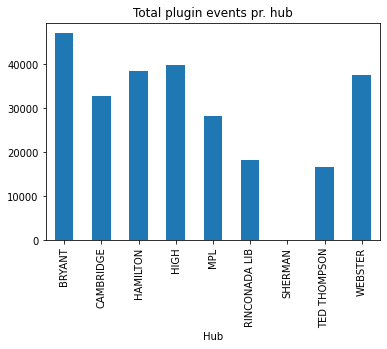

In [16]:
df.groupby('Hub')['Plug In Event Id'].count().plot.bar(title = 'Total plugin events pr. hub')

<AxesSubplot:title={'center':'Total plugs per station'}, xlabel='Station Name'>

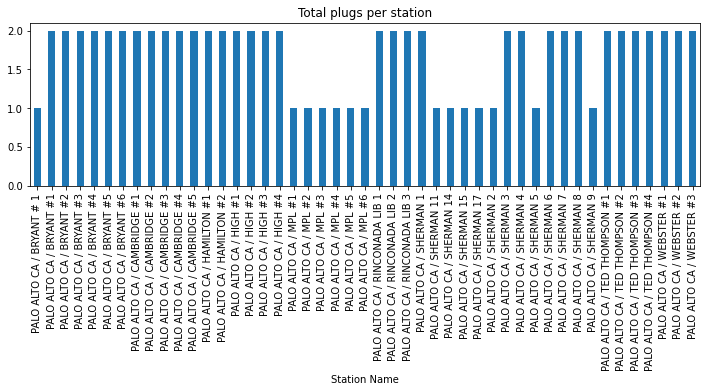

In [17]:
df.groupby('Station Name')['No. Plugs'].first().plot.bar(title = 'Total plugs per station', figsize=(12, 3))

In [18]:
## Find first time a specific plug at a specific station is in use
list_of_first_records = []
for i in df['Station Name'].unique():
    list_of_first_records.append(df[df['Station Name'] == i].iloc[0].values)
df_charging_stations = pd.DataFrame(list_of_first_records)
df_charging_stations = df_charging_stations.set_axis(df.columns.unique().values, axis=1, inplace=False)

In [19]:
## Count no. of charging stations pr. hub over time
df_charging_stations['No. Stations'] = df_charging_stations.groupby('Hub').cumcount()
df_charging_stations['No. Stations'] = df_charging_stations['No. Stations'] + 1
df_charging_stations['No. Plugs per Hub'] = df_charging_stations.groupby('Hub').cumsum()['No. Plugs']
df_charging_stations_per_hub = df_charging_stations[['Station Name', 'Start Date', 'Port Number', 'Hub', 'No. Stations', 'No. Plugs per Hub']]

In [20]:
## Create df with time and hubs as rows and columns respectively. Filled with number of charging stations
df_hub = df_charging_stations_per_hub.pivot_table(values='No. Stations', index=['Start Date'], columns='Hub', aggfunc='first')
df_hub = df_hub.fillna(0)
df_hub = df_hub.replace(to_replace=0, method='ffill')

In [21]:
df_plug_hub = df_charging_stations_per_hub.pivot_table(values='No. Plugs per Hub', index=['Start Date'], columns='Hub', aggfunc='first')
df_plug_hub = df_plug_hub.fillna(0)
df_plug_hub = df_plug_hub.replace(to_replace=0, method='ffill')

<AxesSubplot:title={'center':'No. of plugs pr. hub ($\\tau$)'}, xlabel='Start Date'>

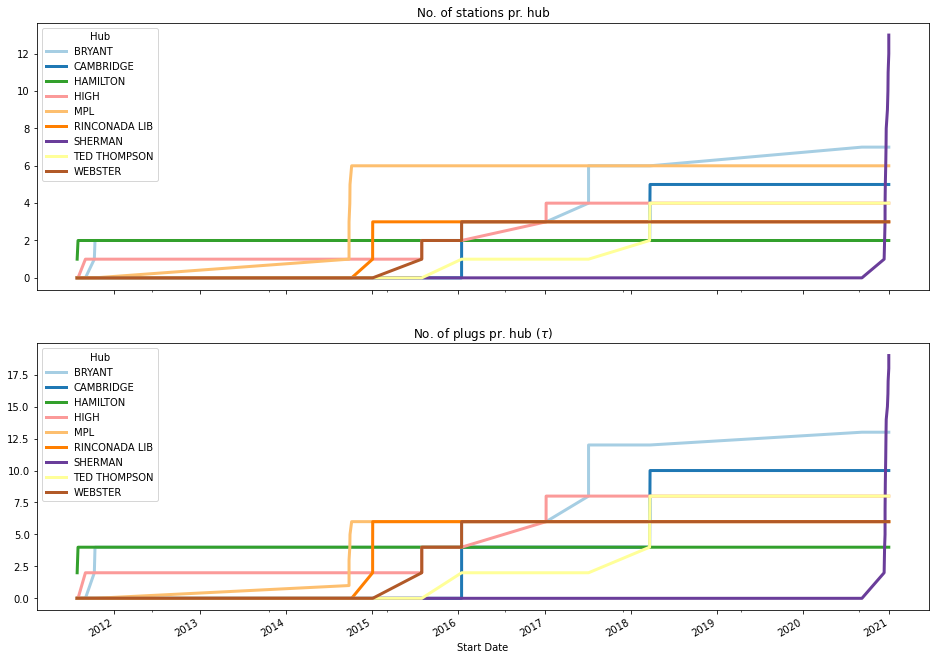

In [22]:
fig, axes = plt.subplots(2, figsize=(16,12), sharex=True)
df_hub.plot(colormap = 'Paired', linewidth = 3, title = 'No. of stations pr. hub', ax=axes[0])
df_plug_hub.plot(colormap = 'Paired', linewidth = 3, title = r'No. of plugs pr. hub ($\tau$)', ax=axes[1])

## Exploring distributions from when the models begin recording

In [3]:
## Read count data format
#df_event = pd.read_csv('Data/charging_session_count_30.csv', index_col=0, parse_dates=['Period'])
df_event = create_count_data(df, interval_length = 30, save = True)



In [6]:
## Getting first record of each station 
first_date_rec = []
j = 0

for i in df_charging_stations['Hub'].unique():
    first_recording = df_charging_stations['Start Date'].loc[df_charging_stations['Hub'] == i].iloc[0]
    first_date_rec.append(first_recording)
    

station_name = df_event.columns.values
hub_start_dict = dict(zip(station_name, first_date_rec))


NameError: name 'df_charging_stations' is not defined

In [12]:
df_event['Cluster'].unique()

array(['HAMILTON', 'HIGH', 'BRYANT', 'MPL', 'RINCONADA', 'WEBSTER', 'TED',
       'CAMBRIDGE', 'SHERMAN'], dtype=object)

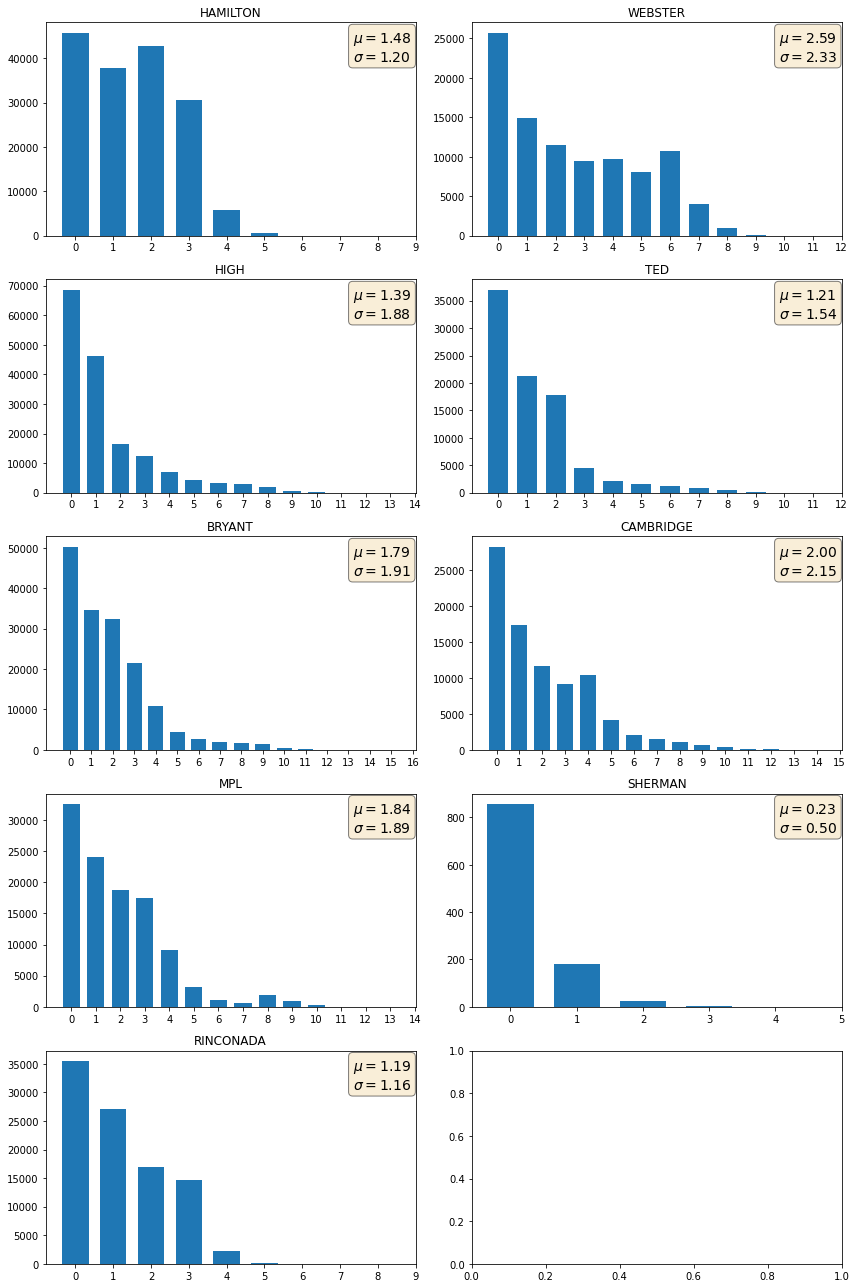

In [13]:
fig, axes = plt.subplots(5,2, figsize=(12, 18))
i = 0
j = 0
for key in df_event['Cluster'].unique():
    cluster_events = df_event['Sessions'].loc[df_event['Cluster'] == key]
    cluster_mean = np.mean(df_event['Sessions'].loc[df_event['Cluster'] == key])
    cluster_sd = np.std(df_event['Sessions'].loc[df_event['Cluster'] == key])

    #cluster_events = df_event[key].values
    #cluster_mean = np.mean(cluster_events)
    #cluster_sd = np.std(cluster_events)

    axes[i,j].hist(cluster_events, bins = range(int(np.max(cluster_events))+3), rwidth=0.7)
    axes[i,j].set_title(str(key))
    axes[i,j].plot()
    axes[i,j].set_xticks(np.arange(np.max(cluster_events)+3) + 0.5)
    axes[i,j].set_xticklabels(np.arange(np.max(cluster_events)+3))

    textstr = '\n'.join((
    r'$\mu=%.2f$' % (cluster_mean, ),
    r'$\sigma=%.2f$' % (cluster_sd, )))
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    axes[i,j].text(0.83, 0.962, textstr, transform=axes[i,j].transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

    i += 1
    if i == 5:
        j += 1
        i = 0
fig.tight_layout()
#fig.savefig("Figures/Distributions.png", bbox_inches='tight')


In [ ]:
### Could attempt to find best fitted pdf to above distributions

## Daily and weekly patterns 
#### Using quantile plots to explore patterns across clusters

In [14]:
## Add day and hour variable
df_event['Day'] = df_event['Period'].dt.dayofweek
df_event['Hour'] = df_event['Period'].dt.hour


In [15]:
def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'percentile_%s' % n
    return percentile_

In [95]:
def tsplot_v2(df, n=2, time_scale = 24, Cluster = 'HAMILTON', percentile_min=10, percentile_max=90, color='r', plot_mean=False, plot_median=True, line_color='k', **kwargs):
    
    x = np.arange(0,time_scale)

    # calculate the lower and upper percentile groups, skipping 50 percentile
    perc1 = np.zeros((n, time_scale))
    perc2 = np.zeros((n, time_scale))

    if time_scale == 7:
        group_var = 'Day'
    else: 
        group_var = 'Hour'


    j = 0
    for i in np.linspace(percentile_min, 50, n):
        perc1[j,:] = df[df['Cluster'] == Cluster].groupby(group_var).agg([percentile(i)])['Sessions'].values.flatten()
        j +=1
    
    k = 0
    for i in np.linspace(50, percentile_max, n):
        perc2[k,:] = df[df['Cluster'] == Cluster].groupby(group_var).agg([percentile(i)])['Sessions'].values.flatten()
        k +=1

    if 'alpha' in kwargs:
        alpha = kwargs.pop('alpha')
    else:
        alpha = 1/n
    # fill lower and upper percentile groups
    for p1, p2 in zip(perc1, perc2):
        plt.fill_between(x, p1, p2, alpha=alpha, color=color, edgecolor=None)

    
    if plot_mean:
        plt.plot(x, df[df['Cluster'] == Cluster].groupby(group_var).mean()['Sessions'].values, color=line_color)

    if plot_median:
        plt.plot(x, df[df['Cluster'] == Cluster].groupby(group_var).median()['Sessions'].values, color=line_color)
    
    return plt.gca(), plt.show()

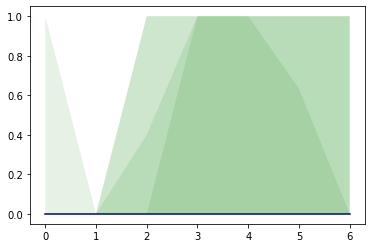

(<AxesSubplot:>, None)

In [99]:
tsplot_v2(df_event, n=10, time_scale = 7, Cluster = 'SHERMAN' ,percentile_min=10, percentile_max=90, plot_median=True, plot_mean=False, color='g', line_color='navy')